# Dependencies

In [1]:
import os, warnings, shutil
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from tokenizers import BertWordPieceTokenizer
from tweet_utility_scripts import *

def seed_everything(seed=0):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')

# pre-process
train_df.dropna(inplace=True)
train_df = train_df.reset_index()
train_df.drop('index', axis=1, inplace=True)
train_df["text"] = train_df["text"].apply(lambda x: x.lower())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.lower())

train_df['text_len'] = train_df['text'].apply(lambda x : len(x))
train_df['selected_text_len'] = train_df['selected_text'].apply(lambda x : len(x))

sentiment_cols = train_df['sentiment'].unique()

print('Train samples: %s' % len(train_df))
display(train_df.head())

Train samples: 27480


,textID,text,selected_text,sentiment,text_len,selected_text_len
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,36,35
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,46,8
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,14
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,75,13


# Tokenizer

In [3]:
MAX_LEN = 128
vocab_path = '/kaggle/input/qa-transformers/distilbert/bert-large-uncased-vocab.txt'

tokenizer = BertWordPieceTokenizer(vocab_path, lowercase=True)
tokenizer.save('./')

['./vocab.txt']

## Tokenizer sanity check

In [4]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 20
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    
    _, y = preprocess_clean(text, selected_text, tokenizer, max_seq_len)
    target_start, target_end = y
    
    decoded_pred = decode_clean(target_start.argmax(), target_end.argmax(), text, tokenizer)
    print('text         : "%s"' % text)
    print('selected_text: "%s"' % decoded_pred)
    print('decoded_pred : "%s"' % selected_text)
    assert decoded_pred == selected_text


Row 0
text         : " i`d have responded, if i were going"
selected_text: "i`d have responded, if i were going"
decoded_pred : "i`d have responded, if i were going"

Row 1
text         : " sooo sad i will miss you here in san diego!!!"
selected_text: "sooo sad"
decoded_pred : "sooo sad"

Row 2
text         : "my boss is bullying me..."
selected_text: "bullying me"
decoded_pred : "bullying me"

Row 3
text         : " what interview! leave me alone"
selected_text: "leave me alone"
decoded_pred : "leave me alone"

Row 4
text         : " sons of ****, why couldn`t they put them on the releases we already bought"
selected_text: "sons of ****,"
decoded_pred : "sons of ****,"


# Hold-out train validation split (20%)

In [5]:
train, validation = train_test_split(train_df, test_size=0.2, random_state=SEED)
print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))

Train samples: 21984
Validation samples: 5496


## Sentiment distribution

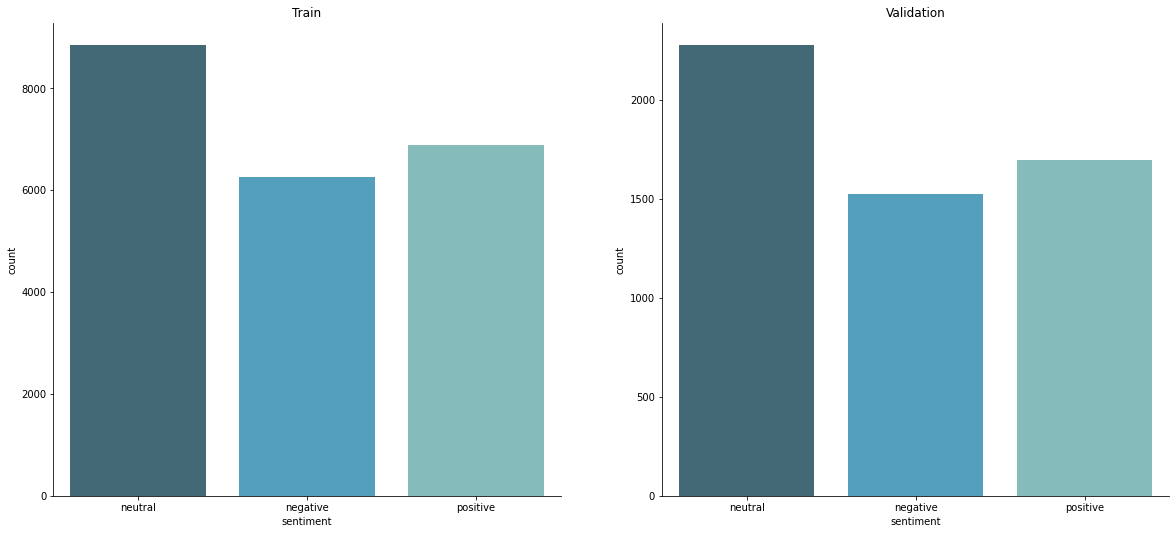

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.7))
sns.countplot(x="sentiment", data=train, palette="GnBu_d", order=sentiment_cols, ax=ax1).set_title('Train')
sns.countplot(x="sentiment", data=validation, palette="GnBu_d", order=sentiment_cols, ax=ax2).set_title('Validation')
sns.despine()
plt.show()

## Lenght distribution

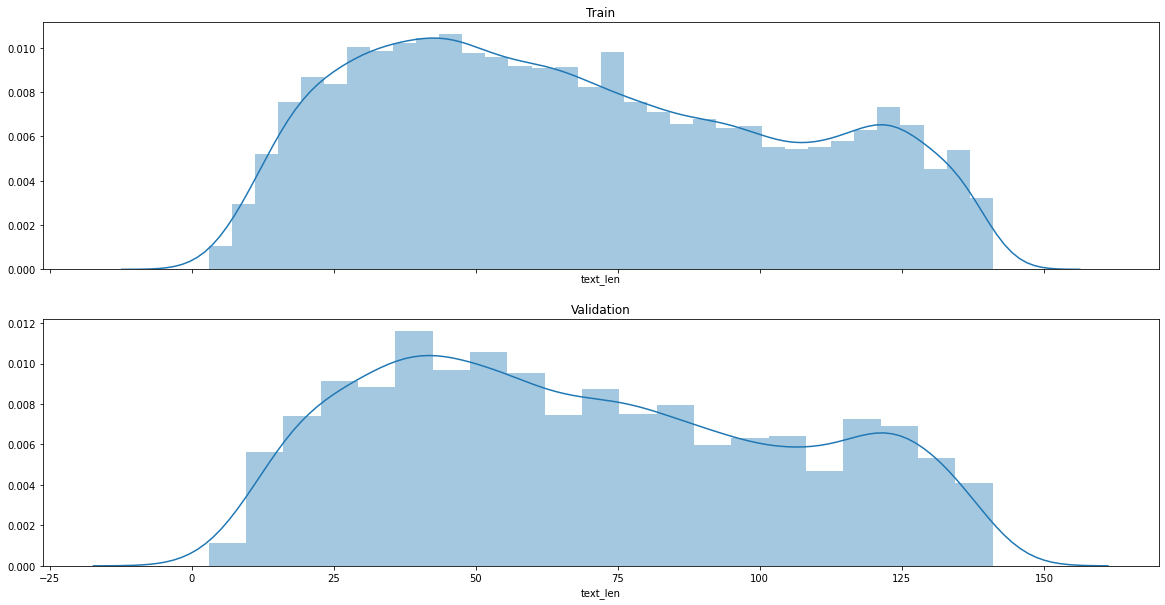

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
sns.distplot(train['text_len'], ax=ax1).set_title("Train")
sns.distplot(validation['text_len'], ax=ax2).set_title("Validation")
plt.show()

## Output hold-out set

In [8]:
train['set'] = 'train'
validation['set'] = 'validation'
train_complete = train.append(validation)
train_complete.to_csv('hold-out.csv', index=False)

base_path = 'hold_out/'
# Create dir
os.makedirs(base_path)
display(train_complete.head())

x_train, y_train = get_data_clean(train, tokenizer, MAX_LEN)
x_valid, y_valid = get_data_clean(validation, tokenizer, MAX_LEN)

np.save(base_path + 'x_train', np.asarray(x_train))
np.save(base_path + 'y_train', np.asarray(y_train))
np.save(base_path + 'x_valid', np.asarray(x_valid))
np.save(base_path + 'y_valid', np.asarray(y_valid))

#  Compress logs dir
!tar -cvzf hold_out.tar.gz hold_out

# Delete logs dir
shutil.rmtree(base_path)

,textID,text,selected_text,sentiment,text_len,selected_text_len,set
24566,a5ca70509c,cant stop playin` in my head -- pussycat doll...,cant stop playin` in my head -- pussycat doll...,neutral,95,95,train
24618,f18b75e863,i hate you,i hate you,negative,11,10,train
19765,649e31adcc,starbucks i`m lovin` it,starbucks i`m lovin` it,positive,23,23,train
21736,8891d08a8c,ben and jerry...yummmmy!!!,.yummmmy!,positive,27,9,train
8979,7fb24b4a56,wow.. purple leopard skin. fieeerrceee..,wow.. purple leopard skin. fieeerrceee..,neutral,42,41,train


hold_out/
hold_out/y_train.npy
hold_out/x_train.npy
hold_out/x_valid.npy
hold_out/y_valid.npy


In [9]:
validation.head()

,textID,text,selected_text,sentiment,text_len,selected_text_len,set
20672,3391184efc,loves the nice weather and 7:30 exams,loves,positive,37,5,validation
12580,b35daf9677,"okay, this weather isn`t 'cute sundress' frien...","okay, this weather isn`t 'cute sundress' frien...",neutral,130,130,validation
13135,06e5249859,woo hoo!! congratulations,congratulations,positive,26,15,validation
14012,3cd4960670,thanks got a hold of someone there who knew...,thanks,positive,68,6,validation
25029,92b75314ca,got back and putting in the laundry. we got in...,got back and putting in the laundry. we got in...,neutral,95,95,validation


# 5-Fold split

In [10]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['sentiment'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 21984, Validation size 5496
Fold: 2, Train size: 21984, Validation size 5496
Fold: 3, Train size: 21984, Validation size 5496
Fold: 4, Train size: 21984, Validation size 5496
Fold: 5, Train size: 21984, Validation size 5496


## Sentiment distribution

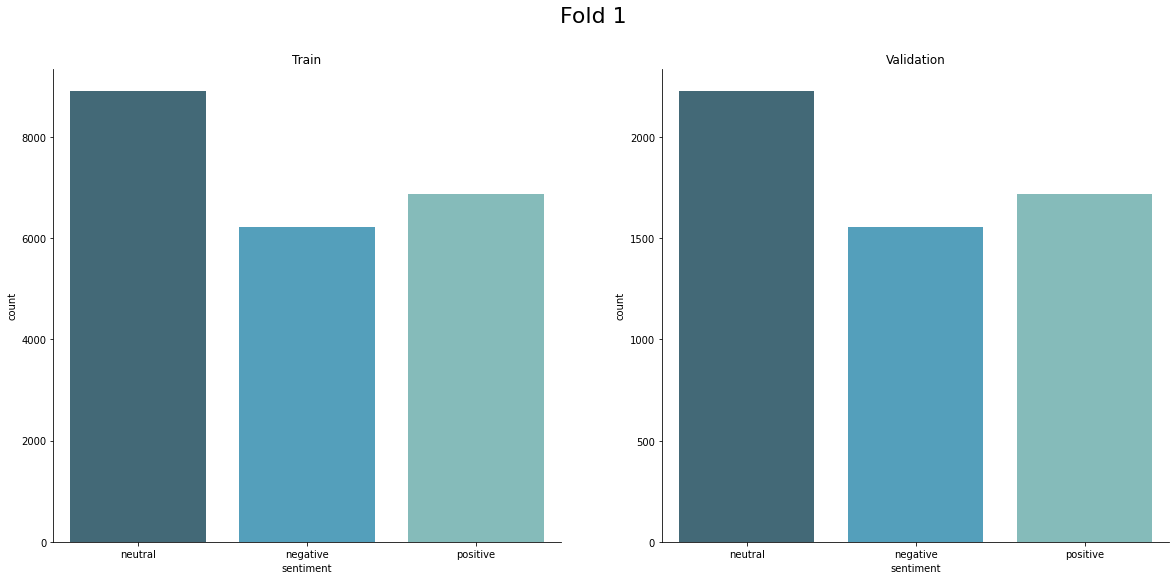

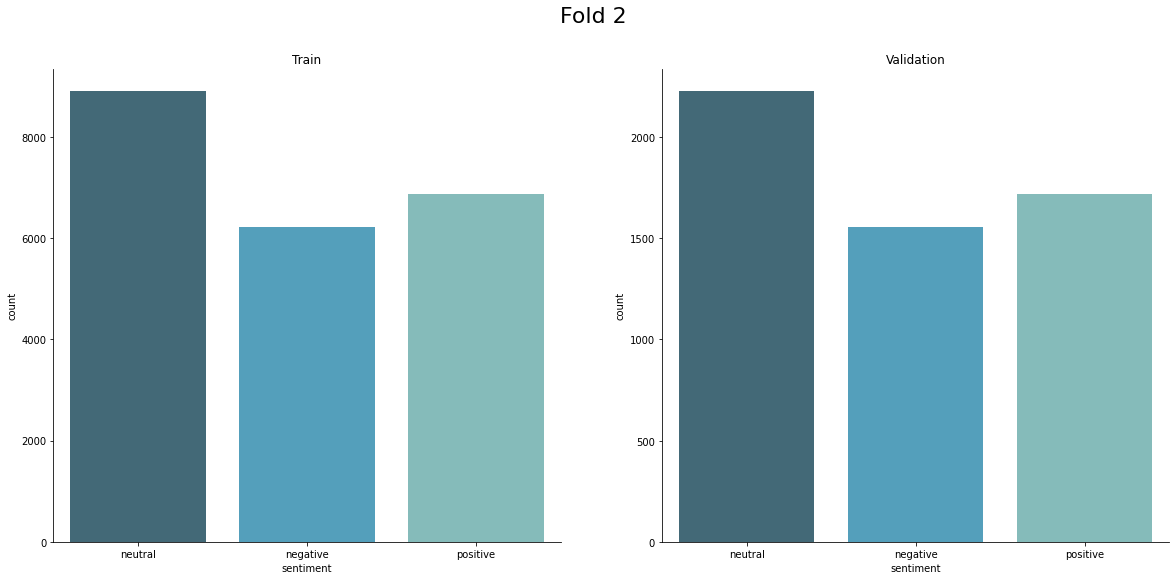

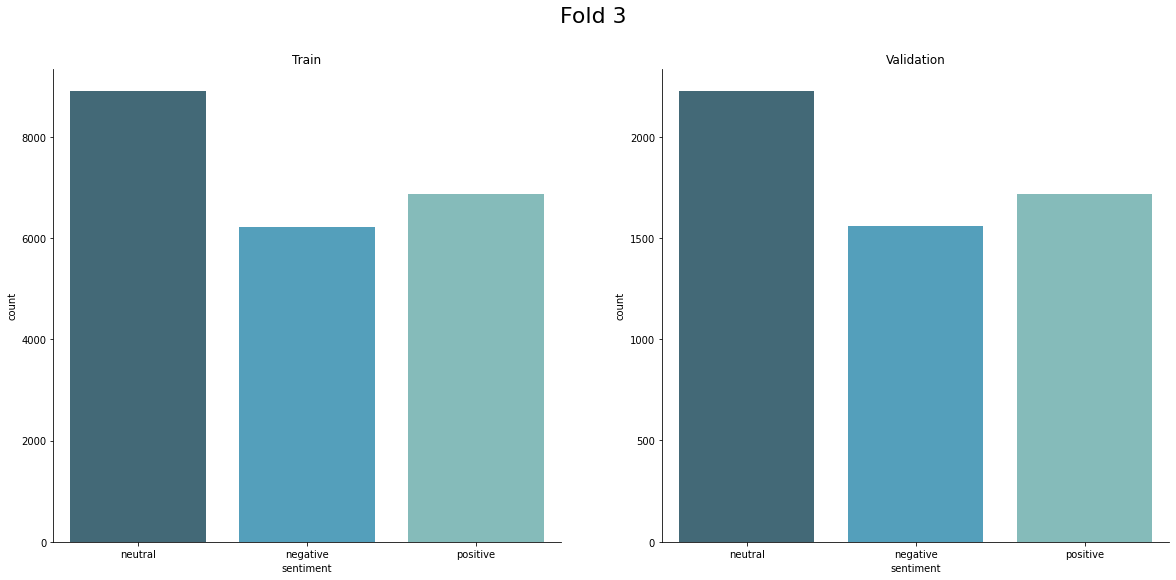

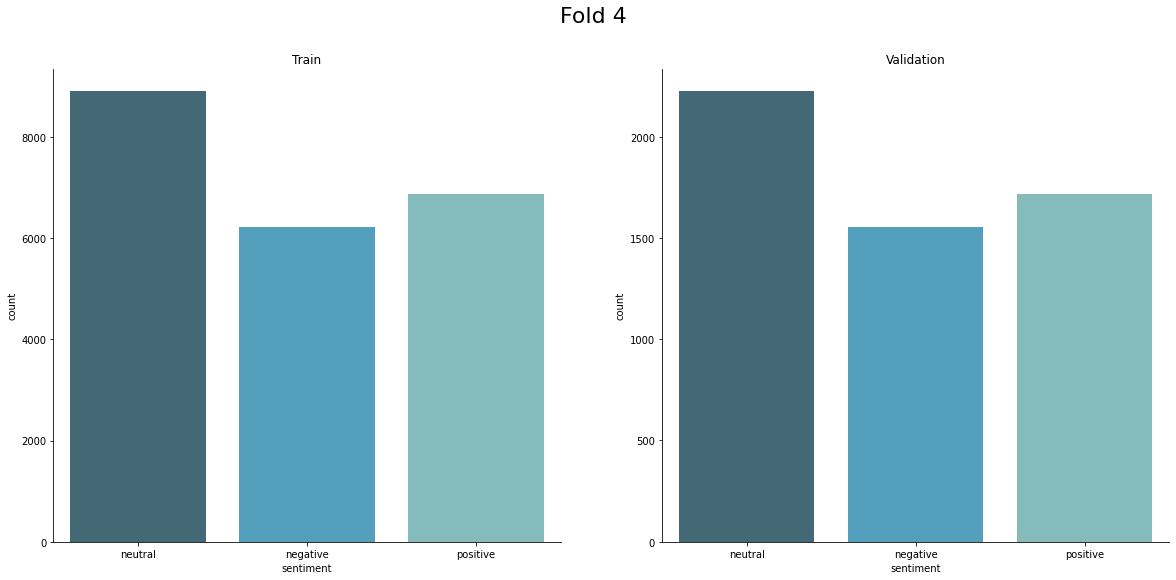

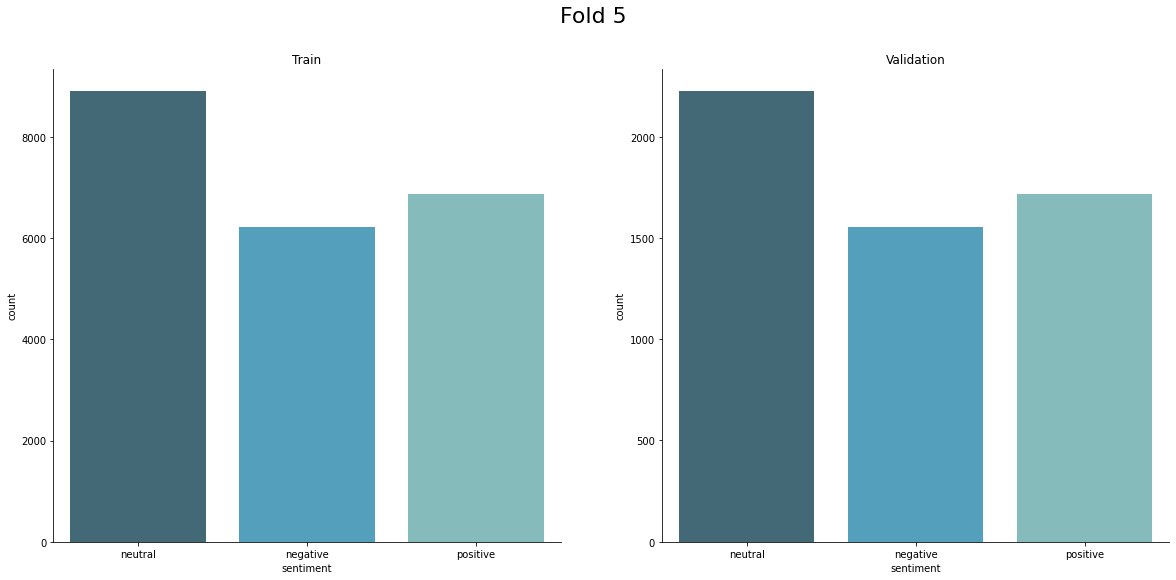

In [11]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.7))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", order=sentiment_cols, ax=ax1).set_title('Train')
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", order=sentiment_cols, ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

## Lenght distribution

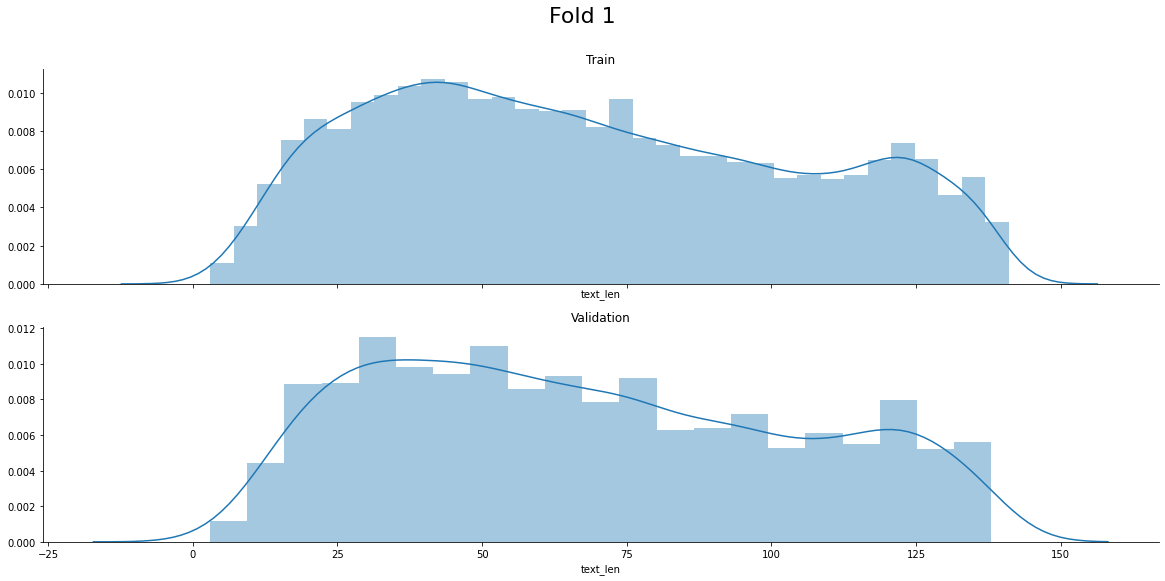

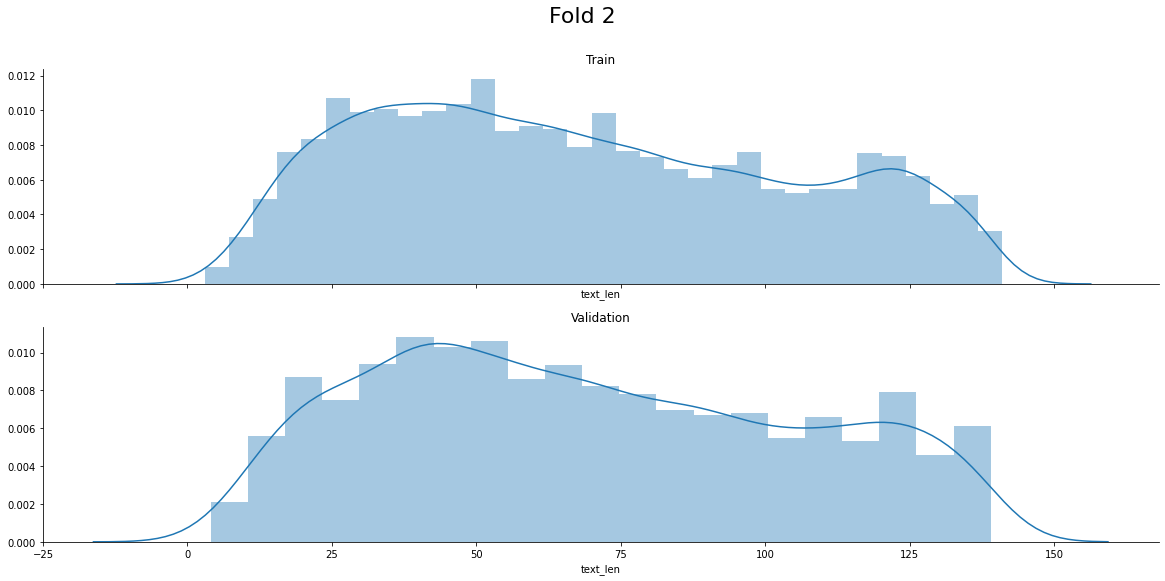

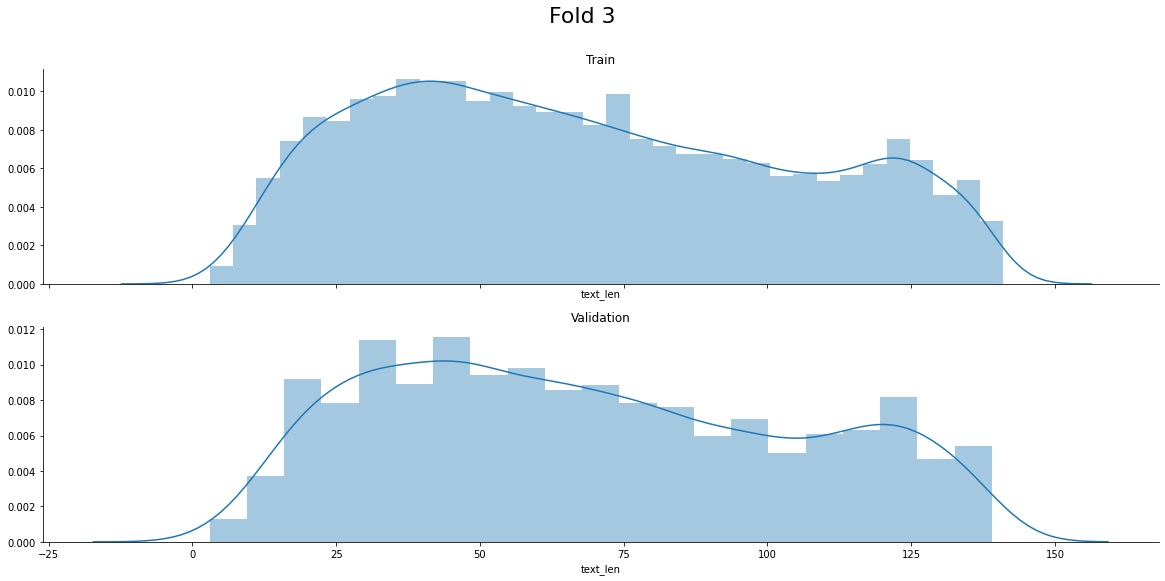

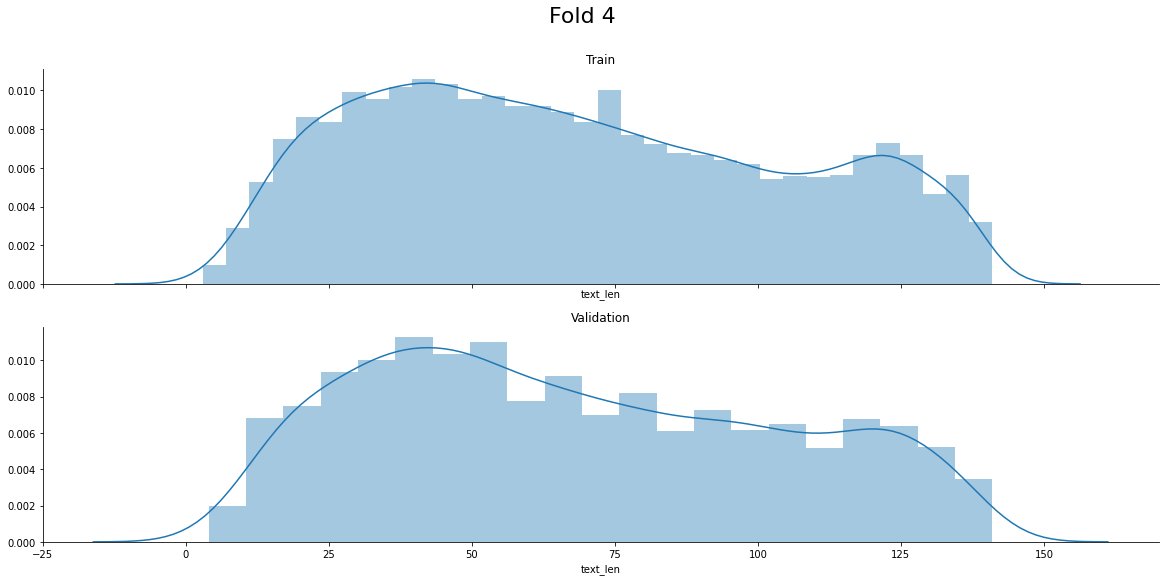

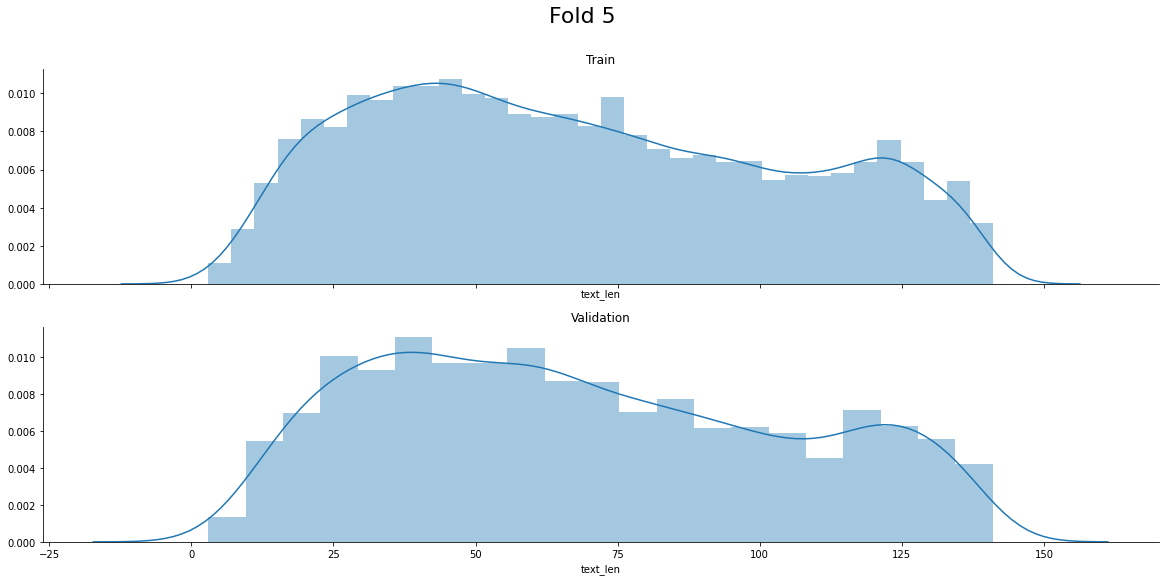

In [12]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
    fig.suptitle('Fold %s' % fold_n, fontsize=22)
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['text_len'], ax=ax1).set_title("Train")
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['text_len'], ax=ax2).set_title("Validation")
    sns.despine()
    plt.show()

## Output 5-fold set

In [13]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    fold_n += 1
    
    base_path = 'fold_%d/' % fold_n
    # Create dir
    os.makedirs(base_path)
    
    x_train, y_train = get_data_clean(train_df[train_df[('fold_%s' % fold_n)] == 'train'], tokenizer, MAX_LEN)
    x_valid, y_valid = get_data_clean(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], tokenizer, MAX_LEN)

    np.save(base_path + 'x_train', np.asarray(x_train))
    np.save(base_path + 'y_train', np.asarray(y_train))
    np.save(base_path + 'x_valid', np.asarray(x_valid))
    np.save(base_path + 'y_valid', np.asarray(y_valid))
    
#  Compress logs dir
!tar -cvzf fold_1.tar.gz fold_1
!tar -cvzf fold_2.tar.gz fold_2
!tar -cvzf fold_3.tar.gz fold_3
!tar -cvzf fold_4.tar.gz fold_4
!tar -cvzf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
shutil.rmtree('fold_2')
shutil.rmtree('fold_3')
shutil.rmtree('fold_4')
shutil.rmtree('fold_5')

,textID,text,selected_text,sentiment,text_len,selected_text_len,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,36,35,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,46,8,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,14,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,75,13,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/x_valid.npy
fold_1/y_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/x_valid.npy
fold_2/y_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/x_valid.npy
fold_3/y_valid.npy
fold_4/
fold_4/y_train.npy
fold_4/x_train.npy
fold_4/x_valid.npy
fold_4/y_valid.npy
fold_5/
fold_5/y_train.npy
fold_5/x_train.npy
fold_5/x_valid.npy
fold_5/y_valid.npy
